# Imports

In [1]:
%%capture
!pip install pysptk
!pip install fairseq
!pip install torch torchvision

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import statistics
import os
import numpy as np
import math
import json
import pandas as pd

import librosa
import pysptk
import IPython.display as ipd
from scipy.io.wavfile import write
import fairseq
import torchaudio

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, ReLU, CrossEntropyLoss, Module, Dropout

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Processing Functions

In [4]:
def analyse_dataset(dataset_path, sr=16000, min_length=1, min_voiced_sec=0.08, max_silence_sec=None):
  """
  Analyses a dataset and returns some data information, includind the files which
  are not valid:
  - Shorter than min_length
  - Empty
  - Without meaningful voiced material
  """
  audio_paths = []
  speaker_labels = []
  audio_lengths = []
  audio_channels = []
  gender_labels = []
  discarded_paths = []

  for root, subdirs, files in os.walk(dataset_path):
    for file in files:
      if file.split('.')[-1] == 'flac' or file.split('.')[-1] == 'wav':
        filepath = os.path.join(root, file)
        label = file.split('-')[0]
        audio, _ = librosa.load(filepath, sr=sr, mono=False)
        # Check if the audio is long enough, valid and has meaningful speech material
        if len(audio) * sr >= min_length and librosa.util.valid_audio(audio, mono=is_mono(audio))\
            and is_voiced(audio, sr, min_voiced_sec, max_silence_sec=max_silence_sec):
            audio_paths.append(filepath)
            speaker_labels.append(label)
            audio_lengths.append(len(audio))
            audio_channels.append(is_mono(audio))
        else:
          discarded_paths.append(filepath)

  return np.array(audio_paths), np.array(speaker_labels),np.array(audio_lengths),\
           np.array(audio_channels), np.array(discarded_paths)

def print_statistics(audio_paths, speaker_labels, audio_lengths, audio_channels, discarded_paths):
  """
  Given the information provided by analyse_dataset prints a series of global and
  class-related statistics about the dataset files. 
  """
  print('GLOBAL STATISTICS')
  print()
  print(' - Tot. n. of audios: {}'.format(len(audio_paths)))
  print(' - Tot. n. of speakers: {}'.format(len(np.unique(np.array(speaker_labels)))))
  print(' - Tot. n. of discarded audios: {}'.format(len(discarded_paths)))
  print(' - Max length: {}'.format(max(audio_lengths) / sr))
  print(' - Min length: {}'.format(min(audio_lengths) / sr))
  print(' - Avg length: {}'.format(sum(audio_lengths) / len(audio_lengths) / sr))
  print(' - Median length: {}'.format(statistics.median(audio_lengths) / sr))
  print(' - Number of mono audios: {}'.format((audio_channels == True).sum()))
  print(' - Number of stereo audios: {}'.format((audio_channels == False).sum()))  
  print()
  print()
  print()
  print('SPEAKER STATISTICS')
  print()
  for i, speaker in enumerate(np.unique(speaker_labels)):
    spk_indices = np.where(speaker_labels == speaker)[0]
    spk_audio_lengths = [audio_lengths[i] for i in spk_indices]
    spk_audio_channels = [audio_channels[i] for i in spk_indices]
    print('{}) Speaker id: {}'.format(i + 1, speaker))
    print('     - N. audios: {}'.format(len(spk_indices)))
    print('     - Max length: {}'.format(max(spk_audio_lengths) / sr))
    print('     - Min length: {}'.format(min(spk_audio_lengths) / sr))
    print('     - Avg length: {}'.format(sum(spk_audio_lengths) / 
                                    len(spk_audio_lengths) / sr))
    print('     - Median length: {}'.format(statistics.median(spk_audio_lengths) / sr))


def save_dataset(audio_paths, speaker_categorical_labels, json_path):
  """
  Save the dataset as a json file
  """
  data = {
    "speaker_mappings": [],
    "speaker_labels": [],
    "files": []
  }
    
  le = preprocessing.LabelEncoder()
  le.fit(speaker_categorical_labels)
  speaker_labels = le.transform(speaker_categorical_labels)

  data["speaker_mappings"] = np.unique(speaker_categorical_labels).tolist()
  data["speaker_labels"] = speaker_labels.tolist()
  data["files"] = audio_paths.tolist()

  with open(json_path, "w") as fp:
    json.dump(data, fp, indent=4)
    
  print("Saved to {}".format(json_path))

def extract_speaker_features(json_path, X, y, num_speakers=None, average_time=False):
  """
  Extract the speaker features using the wav2vec2.0 encoder. The original features
  shape is [1, 512, 99] where the first one is the batch size, the second one are 
  the extracted coefficients and the third one is the temporal dimension.
  To ease the computation is possible to select a subset of speakers and average
  the coefficients among the time axis.
  """
  data = {
      "speaker_features": [],
      "speaker_labels": []
  }

  cp_path = os.path.join(trained_models_path,'wav2vec_small.pt')
  model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([cp_path])
  model = model[0]
  model.eval()

  selected_speakers = np.unique(y)
  if num_speakers != None:
    selected_speakers = np.random.choice(selected_speakers, size=num_speakers, replace=False)
    print("Selected Speakers: {}".format(selected_speakers))
    
  for i, audio_path in enumerate(X):
    if y[i] in selected_speakers:
      audio, _ = torchaudio.load(audio_path)
      feature = model.feature_extractor(audio).tolist()
      if average_time:
        avg_feat = [statistics.mean(coeff) for coeff in feature[0]]
        data["speaker_features"].append(avg_feat)
      else:
        data["speaker_features"].append(feature)
      data["speaker_labels"].append(y[i])

  with open(json_path, "w") as fp:
    json.dump(data, fp, indent=4)
    
  print("Saved to {}".format(json_path))

def load_dataset(data_path, features=False):
  """
  Load the dataset from a json file
  """
  with open(data_path, 'r') as fp:
    data = json.load(fp)

  y = data["speaker_labels"]

  if features == True:
    X = data["speaker_features"]
    return X, y

  else:
    X = data["files"]
    classes = data["speaker_mappings"]
    return X, y, classes


# Utility Functions

In [5]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def is_mono(audio):
  if audio.shape[0] == 2:
      return False
  else:
    return True

def is_voiced(audio, sr, min_voiced_sec, plot=False, max_silence_sec=None):
  """
  Detects the presence of voiced segments (longer than min_voiced_sec) in an audio
  by performing pitch tracking over the human voice range. If max_silence_sec is
  passed it detects the overall amount of silence in the audio and marks it as 
  unvoiced if it is higher than max_silence_sec.
  """
  data_audiof = np.asarray(audio * (2 ** 15), dtype=np.float32)
  size_stepS = 0.001 * sr
  F0 = pysptk.sptk.rapt(data_audiof, sr, size_stepS, min=50, max=500, 
                        voice_bias=-0.2, otype='f0')
  pitchON = np.where(F0 != 0)[0]
  pitchON = consecutive(pitchON)
  if plot:
    plt.subplot(2, 1, 1)
    plt.plot(audio)
    plt.subplot(2, 1, 2)
    plt.plot(F0)
  if max_silence_sec != None:
    total_voiced = [item for sublist in pitchON for item in sublist]
    total_silence_sec = (len(audio) - len(total_voiced) * size_stepS) / sr
    if total_silence_sec > max_silence_sec:
      return False
    else:
      return True

  n_voiced_seg = len([True for x in pitchON if len(x) > min_voiced_sec * sr / size_stepS])
  if n_voiced_seg > 0:
    return True
  else:
    return False

def samples_each_class(labels, classes):
  """
  Returns the number of samples for each class
  """
  samples_class_num = []
  for i, c in enumerate(classes):
    samples_class = len([el for el in labels if el == c])
    samples_class_num.append(samples_class)
    print("Class {}: {} samples".format(i, samples_class))
  return samples_class_num

def select_classes(X, y, num_classes):
  """
  Select only the samples belonging to a subset of classes
  """
  selected_classes = np.random.choice(np.unique(y), size=num_classes, replace=False)
  selected_features = [x for i, x in enumerate(X) if y[i] in selected_classes]
  selected_labels = [label for i, label in enumerate(y) if label in selected_classes]
  return selected_features, selected_labels, selected_classes

# Global Variables

In [6]:
sr = 16000
min_length = 1 
min_voiced_sec = 0.08
max_silence_sec = 1.5
n_mfcc = 13
processed_dataset_path = '/content/drive/MyDrive/Voiseed/processed_dataset'
speaker_dataset_path = '/content/drive/MyDrive/Voiseed/speaker_dataset.json'
speaker_features_path = '/content/drive/MyDrive/Voiseed/speaker_features_dataset_avg.json'
trained_models_path = '/content/drive/MyDrive/Voiseed/models'

# Preliminary Dataset Analysis

Per questo secondo task utilizzo il dataset creato nel primo frammentando gli audio in segmenti di due secondi. Chiamo poi la stessa funzione (analyse_dataset) per analizzare i dati in input ed eventualmente scartare quelli che non contengono materiale significativo. Questa volta ho scelto di aggiungere un controllo sulla quantità di silenzio contenuta in ogni audio così da scartare quelli che ne contenessero più di max_silence_sec secondi.
Non effettuando infatti l'outlier detection come per il primo task con gli MFCC, devo assicurarmi a priori di avere audio con sufficiente parlato.

In [15]:
audio_paths, speaker_labels, gender_labels, audio_lengths, audio_channels, discarded_paths =\
    analyse_dataset(preprocessed_dataset_path, min_length=min_length,\
                    min_voiced_sec=min_voiced_sec, max_silence_sec=max_silence_sec)

In [16]:
print_statistics(audio_paths, speaker_labels, audio_lengths, 
                 audio_channels, discarded_paths)

GLOBAL STATISTICS

 - Tot. n. of audios: 9231
 - Tot. n. of speakers: 40
 - Tot. n. of discarded audios: 1852
 - Max length: 2.0
 - Min length: 2.0
 - Avg length: 2.0
 - Median length: 2.0
 - Number of mono audios: 9231
 - Number of stereo audios: 0



SPEAKER STATISTICS

1) Speaker id: 1272
     - N. audios: 218
     - Max length: 2.0
     - Min length: 2.0
     - Avg length: 2.0
     - Median length: 2.0
2) Speaker id: 1462
     - N. audios: 228
     - Max length: 2.0
     - Min length: 2.0
     - Avg length: 2.0
     - Median length: 2.0
3) Speaker id: 1673
     - N. audios: 235
     - Max length: 2.0
     - Min length: 2.0
     - Avg length: 2.0
     - Median length: 2.0
4) Speaker id: 174
     - N. audios: 221
     - Max length: 2.0
     - Min length: 2.0
     - Avg length: 2.0
     - Median length: 2.0
5) Speaker id: 1919
     - N. audios: 213
     - Max length: 2.0
     - Min length: 2.0
     - Avg length: 2.0
     - Median length: 2.0
6) Speaker id: 1988
     - N. audios: 229
 

False


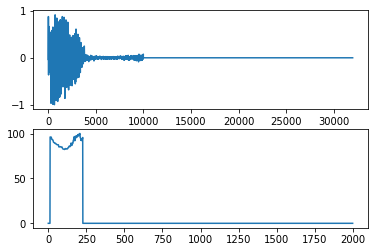

In [18]:
# Inspect discarded audios
audio, _ = librosa.load(discarded_paths[0], sr)
print(is_voiced(audio, sr, min_voiced_sec=min_voiced_sec, plot=True, max_silence_sec=1.7))
ipd.Audio(audio, rate=sr)

# Save the Dataset
Per comodità salvo le informazioni del nuovo dataset in un file json, per evitare di rianalizzarlo ogni volta.

In [19]:
save_dataset(audio_paths, speaker_labels, speaker_dataset_path)

Saved to /content/drive/MyDrive/Voiseed/speaker_dataset.json


# Load the Dataset

In [6]:
X, y, classes = load_dataset(speaker_dataset_path)

# Wav2vec Features Extraction
Estraggo le feature usate per rappresentare i dati con il modello wav2vec2.0. Le dimensioni originali sono [1, 512, 99], ma, avendo avuto dei problemi di memoria nell'estrarle per tutti gli audio, ho scelto di calcolare la media dei 512 coefficienti lungo l'asse temporale (di dimensione 99). In questo modo ottengo un vettore di lungheza 512 che poi salvo in un file json insieme alle altre informazioni.

In [72]:
extract_speaker_features(speaker_features_path, X, y, average_time=True)

Saved to /content/drive/MyDrive/Voiseed/speaker_features_dataset_avg.json


In [7]:
features, labels = load_dataset(speaker_features_path, features=True)

# Feature Normalization




Normalizzo le feature per assicurarmi che siano confrontabili

In [8]:
standard_scaler = preprocessing.StandardScaler()
scaled_features = standard_scaler.fit_transform(features)

# Create Dataset Partitions

Avendo visto dalle statistiche che le 40 classi contengono numeri simili di audio ho pensato non fosse necessario bilanciare il dataset. Nel creare train, eval e test ho sfruttato il parametro sratify per assicurare che la stessa distribuzione di audio tra le classi nel dataset di partenza fosse mantenuta anche nelle partizioni. Come si può vedere dalla seconda cella infatti anche le tre partizioni risultano bilanciate e non ci sono divari tra il numero di audio nelle varie classi

In [11]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features, labels, test_size = 0.1, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, stratify=y_train)

classes = np.unique(labels)

print('Training Samples: {}'.format(len(X_train)))
print('Validation Samples: {}'.format(len(X_val)))
print('Test Samples: {}'.format(len(X_test)))

Training Samples: 7476
Validation Samples: 831
Test Samples: 924


In [12]:
print("Train Classes Balance")
train_count = samples_each_class(y_train, classes)
print()
print("Eval Classes Balance")
eval_count = samples_each_class(y_val, classes)
print()
print("Test Classes Balance")
test_count = samples_each_class(y_test, classes)



Train Classes Balance
Class 0: 176 samples
Class 1: 185 samples
Class 2: 190 samples
Class 3: 179 samples
Class 4: 173 samples
Class 5: 185 samples
Class 6: 193 samples
Class 7: 193 samples
Class 8: 185 samples
Class 9: 182 samples
Class 10: 188 samples
Class 11: 190 samples
Class 12: 188 samples
Class 13: 186 samples
Class 14: 192 samples
Class 15: 187 samples
Class 16: 189 samples
Class 17: 183 samples
Class 18: 190 samples
Class 19: 198 samples
Class 20: 188 samples
Class 21: 191 samples
Class 22: 193 samples
Class 23: 194 samples
Class 24: 191 samples
Class 25: 194 samples
Class 26: 187 samples
Class 27: 198 samples
Class 28: 179 samples
Class 29: 190 samples
Class 30: 176 samples
Class 31: 189 samples
Class 32: 193 samples
Class 33: 172 samples
Class 34: 184 samples
Class 35: 185 samples
Class 36: 191 samples
Class 37: 170 samples
Class 38: 191 samples
Class 39: 188 samples

Eval Classes Balance
Class 0: 20 samples
Class 1: 20 samples
Class 2: 21 samples
Class 3: 20 samples
Class 

# Machine Learning Classifiers

Come classificatori di Machine Learning ho scelto di usare gli stessi del task precedente e di prenderli come baseline per confrontare le performance con un modello di Deep Learning. Come metriche per valutare i modelli ho scelto precision, recall, f1-score per le varie classi e l'accuracy totale, mostrate nel classification report.

## Random Forest (First Baseline)




Rispetto al task 1 il Random Forest ottiene un'accuracy complessiva molto inferiore. Questo evidenzia come il problema d speaker recognition con 40 classi sia più complesso rispetto ad una classificazione binaria. Alcune classi hanno delle performance molto basse come ad esempio la 35 in cui nessuno dei 23 audio viene classificato correttamente. Inoltre si può notare come molte classi abbiano dei valori di precision e recall molto diversi tra loro, evidenziando aspetti diversi del classificatore, mentre F1 score, essendo la media armonica tra i due, riassume le performance generali del metodo in relazione alla classe.

In [47]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.95      0.84        22
           1       0.58      0.48      0.52        23
           2       0.42      0.96      0.59        23
           3       0.93      0.59      0.72        22
           4       0.75      0.14      0.24        21
           5       1.00      0.13      0.23        23
           6       0.35      0.96      0.52        24
           7       0.71      0.92      0.80        24
           8       0.85      0.48      0.61        23
           9       0.62      0.68      0.65        22
          10       0.82      0.61      0.70        23
          11       0.62      0.67      0.64        24
          12       0.79      0.83      0.81        23
          13       0.44      0.17      0.25        23
          14       0.92      0.92      0.92        24
          15       0.70      1.00      0.82        23
          16       0.54      0.87      0.67        23
          17       0.64    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Support Vector Machine (Second Baseline)

Analogamente al primo task SVM raggiunge delle performance quasi massime. 

In [48]:
clf = SVC(gamma='auto', probability=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      0.96      0.98        23
           2       1.00      1.00      1.00        23
           3       1.00      1.00      1.00        22
           4       0.95      1.00      0.98        21
           5       1.00      1.00      1.00        23
           6       0.96      0.96      0.96        24
           7       0.96      1.00      0.98        24
           8       1.00      0.96      0.98        23
           9       1.00      1.00      1.00        22
          10       0.96      0.96      0.96        23
          11       1.00      1.00      1.00        24
          12       0.92      1.00      0.96        23
          13       1.00      1.00      1.00        23
          14       1.00      1.00      1.00        24
          15       1.00      1.00      1.00        23
          16       1.00      1.00      1.00        23
          17       1.00    

# Deep Learning Model

Essendo le feature che rappresentano gli speaker dei tensori di PyTorch ho scelto di usare questo framework al posto di TensorFlow. Come modello di DeepLearning ho scelto il Multilayer Perceptron avendo dei vettori come feature.

## Training Hyperparameters

In [28]:
EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X_train[0])
NUM_CLASSES = len(classes)

# Create Dataloaders


Anche in questo caso durante il training i dati vengono passati sotto forma di batch di dimensione BATCH_SIZE. Per farlo ho creato dei dataloader, uno per ogni partizione, che durante il training e l'evaluation passano i batch di dati e li cancellano dalla memoria una volta analizzati.


In [29]:
class FeatureDataset(Dataset):
  def __init__(self, features, labels):
    self.features = features
    self.labels = labels

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    feature = torch.tensor(self.features[idx]).float()
    label = torch.tensor(self.labels[idx]).long()

    return feature, label

training_data = FeatureDataset(X_train, y_train)
validation_data = FeatureDataset(X_val, y_val)
test_data = FeatureDataset(X_test, y_test)


training_loader = DataLoader(training_data, batch_size=BATCH_SIZE, 
                             drop_last=True, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=1)
test_loader = DataLoader(test_data, batch_size=1)


## Create MLP model
La rete è composta da un input layer, due hidden layers e un output layer, alternati da batch normalization e dropout per evitare l'overfitting.

In [30]:
class MulticlassClassification(nn.Module):
  def __init__(self, num_feature, num_class):
    super(MulticlassClassification, self).__init__()
    
    self.layer_1 = nn.Linear(num_feature, 512)
    self.layer_2 = nn.Linear(512, 128)
    self.layer_3 = nn.Linear(128, 64)
    self.layer_out = nn.Linear(64, num_class) 
    
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.2)
    self.batchnorm1 = nn.BatchNorm1d(512)
    self.batchnorm2 = nn.BatchNorm1d(128)
    self.batchnorm3 = nn.BatchNorm1d(64)
    
  def forward(self, x):
    x = self.layer_1(x)
    x = self.batchnorm1(x)
    x = self.relu(x)
    
    x = self.layer_2(x)
    x = self.batchnorm2(x)
    x = self.relu(x)
    x = self.dropout(x)
    
    x = self.layer_3(x)
    x = self.batchnorm3(x)
    x = self.relu(x)
    x = self.dropout(x)
    
    x = self.layer_out(x)
    
    return x

Come loss function ho usato la CrossEntropy trattandosi di una classificazione multiclasse e come optimizer l'Adam (come per il primo task)

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=512, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=40, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [32]:
def multi_acc(y_pred, y_test):
  y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
  _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
  
  correct_pred = (y_pred_tags == y_test).float()
  acc = correct_pred.sum() / len(correct_pred)
  
  acc = torch.round(acc * 100)
  
  return acc

In [33]:
accuracy_stats = {
  'train': [],
  "val": []
}
loss_stats = {
  'train': [],
  "val": []
}

## Training

Già dalle prime epoche si ottiene un'accuracy molto alta per entrambe le partizioni, considero quindi solo 10 epoche e il modello raggiunge un'accuracy quasi perfetta, non overfittando.

In [34]:
print("Begin training.")
for e in range(EPOCHS+1):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in training_loader:
      X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
      optimizer.zero_grad()
      y_train_pred = model(X_train_batch)
      train_loss = criterion(y_train_pred, y_train_batch)
      train_acc = multi_acc(y_train_pred, y_train_batch)
      
      train_loss.backward()
      optimizer.step()
      
      train_epoch_loss += train_loss.item()
      train_epoch_acc += train_acc.item()
        
    # VALIDATION    
    with torch.no_grad():
      
      val_epoch_loss = 0
      val_epoch_acc = 0
      
      model.eval()
      for X_val_batch, y_val_batch in validation_loader:
        X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
        y_val_pred = model(X_val_batch)
                    
        val_loss = criterion(y_val_pred, y_val_batch)
        val_acc = multi_acc(y_val_pred, y_val_batch)
        
        val_epoch_loss += val_loss.item()
        val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(training_loader))
    loss_stats['val'].append(val_epoch_loss/len(validation_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(training_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(validation_loader))
                              
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(training_loader):.5f} | Val Loss: {val_epoch_loss/len(validation_loader):.5f} | Train Acc: {train_epoch_acc/len(training_loader):.3f}| Val Acc: {val_epoch_acc/len(validation_loader):.3f}')

Begin training.
Epoch 000: | Train Loss: 2.00333 | Val Loss: 0.66979 | Train Acc: 70.489| Val Acc: 98.436
Epoch 001: | Train Loss: 0.52054 | Val Loss: 0.15929 | Train Acc: 97.052| Val Acc: 99.278
Epoch 002: | Train Loss: 0.20752 | Val Loss: 0.07653 | Train Acc: 98.571| Val Acc: 99.278
Epoch 003: | Train Loss: 0.12212 | Val Loss: 0.05270 | Train Acc: 98.996| Val Acc: 99.158
Epoch 004: | Train Loss: 0.09531 | Val Loss: 0.04591 | Train Acc: 98.828| Val Acc: 99.158
Epoch 005: | Train Loss: 0.05842 | Val Loss: 0.03377 | Train Acc: 99.472| Val Acc: 99.158
Epoch 006: | Train Loss: 0.04765 | Val Loss: 0.02588 | Train Acc: 99.433| Val Acc: 99.278
Epoch 007: | Train Loss: 0.04808 | Val Loss: 0.02854 | Train Acc: 99.408| Val Acc: 99.278
Epoch 008: | Train Loss: 0.05477 | Val Loss: 0.04657 | Train Acc: 98.918| Val Acc: 98.676
Epoch 009: | Train Loss: 0.04225 | Val Loss: 0.02104 | Train Acc: 99.124| Val Acc: 99.639
Epoch 010: | Train Loss: 0.03098 | Val Loss: 0.02023 | Train Acc: 99.485| Val Acc: 9

## Inspect Train & Validation accuracy/loss

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

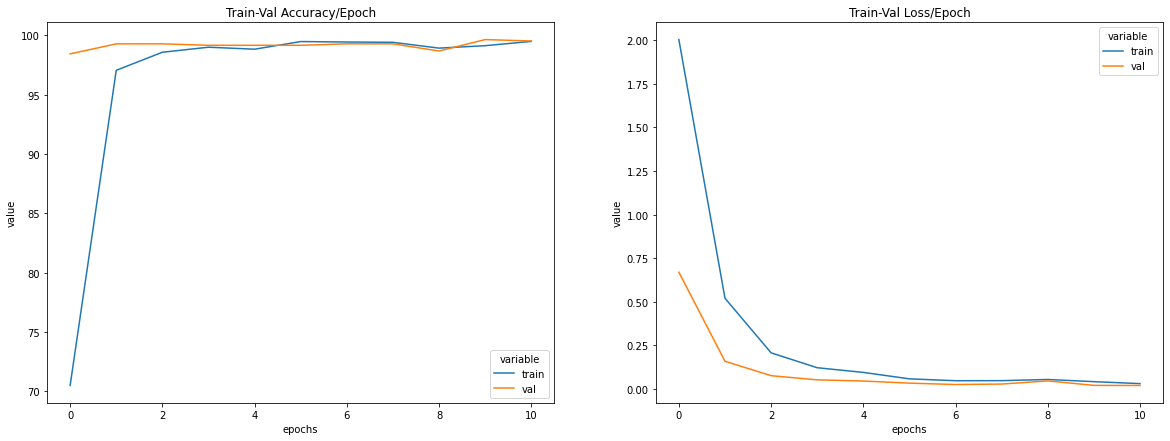

In [35]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

## Metrics

Come metriche per valutare le performance ho plottato la matrice di confusione ed il classification report come per i classificatori precedenti.
I valori delle metriche sono paragonabili a quelli dell'SVM, anche se guardando i risultati parziali sembranno leggermente meglio. Anche per questo task si conferma più che sufficiente l'utilizzo di un modello di Machine Learning senza dover ricorrere al Deep Learning

In [36]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

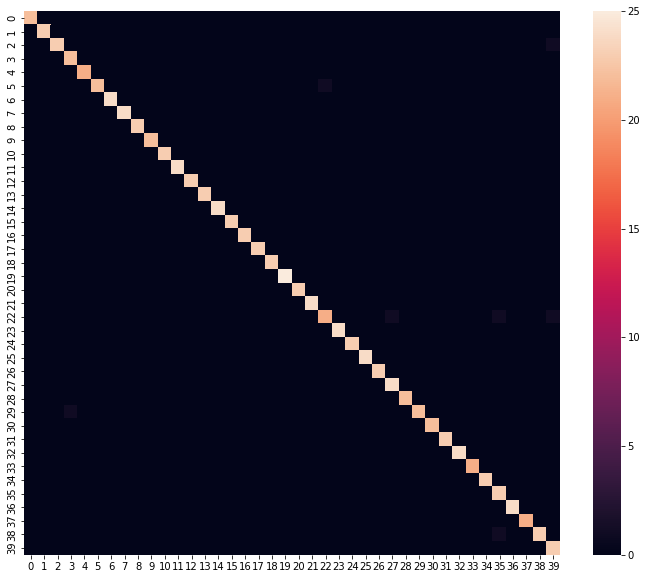

In [37]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list))

plt.figure(figsize=(12,10))
sns.heatmap(confusion_matrix_df, annot=False)

In [38]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        23
           2       1.00      0.96      0.98        24
           3       0.96      1.00      0.98        22
           4       1.00      1.00      1.00        21
           5       1.00      0.96      0.98        23
           6       1.00      1.00      1.00        24
           7       1.00      1.00      1.00        24
           8       1.00      1.00      1.00        23
           9       1.00      1.00      1.00        22
          10       1.00      1.00      1.00        23
          11       1.00      1.00      1.00        24
          12       1.00      1.00      1.00        23
          13       1.00      1.00      1.00        23
          14       1.00      1.00      1.00        24
          15       1.00      1.00      1.00        23
          16       1.00      1.00      1.00        23
          17       1.00    

# Feature Reduction & Clustering

Ho scelto due metodi diversi per fare feature reduction: PCA e t-Sne. Successivamente ho evidenziato i cluster tramite l'algoritmo k-means.

# PCA

Come prima prova ho ridotto il feature space da 512 a due dimensioni con PCA considerando tutti i dati a disposizione. Tuttavia, come si può vedere il plot è molto confuso e le classi non sembrano separate. Ho provato quindi poi a considerare solo 5 speaker e vedere se la separazione fosse più chiara.

In [65]:
pca_df = pd.DataFrame()
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
pca_df = pd.DataFrame()
pca_df['pca-one'] = pca_result[:,0]
pca_df['pca-two'] = pca_result[:,1]
pca_df['y'] = labels 

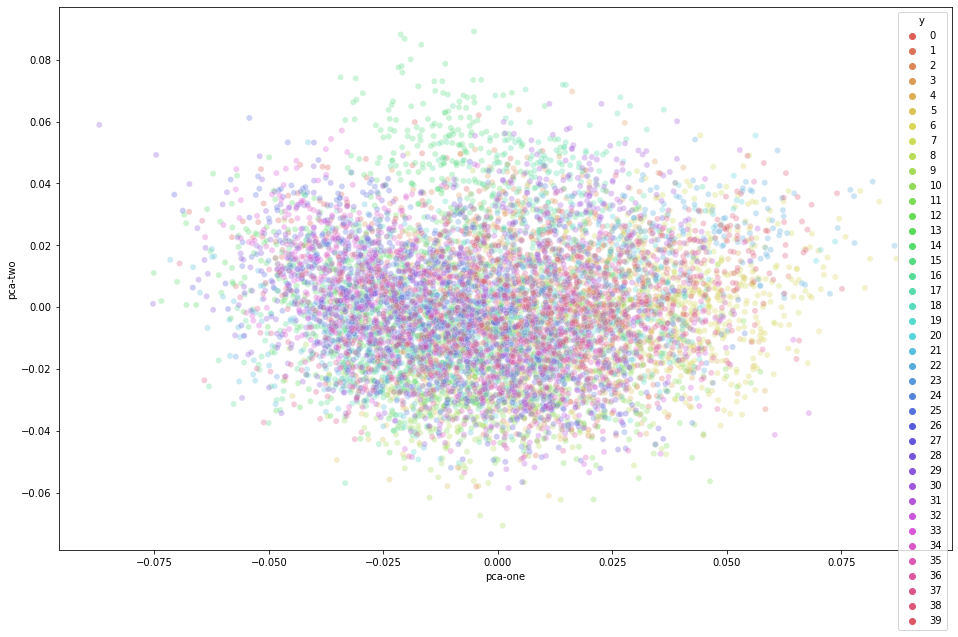

In [66]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", len(classes)),
    data=pca_df,
    legend="full",
    alpha=0.3
)

Sia nel caso bidimensionale che tridimensionale (in cui riduco il feature space a 3 dimesioni) risulta essere molto più evidente la separazione, ma comunque non così netta. Questo probabilmente perchè la distribuzione dei dati non è lineare ed essendo PCA una proiezione di uno spazio multidimensionale su un iperpiano di dimensioni ridotte si perde la non linearità.

In [39]:
selected_features, selected_labels, selected_classes = select_classes(features, labels, 5)

In [40]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(selected_features)
pca_selected_df = pd.DataFrame()
pca_selected_df['pca-one'] = pca_result[:,0]
pca_selected_df['pca-two'] = pca_result[:,1]
pca_selected_df['pca-three'] = pca_result[:,2]
pca_selected_df['y'] = selected_labels 


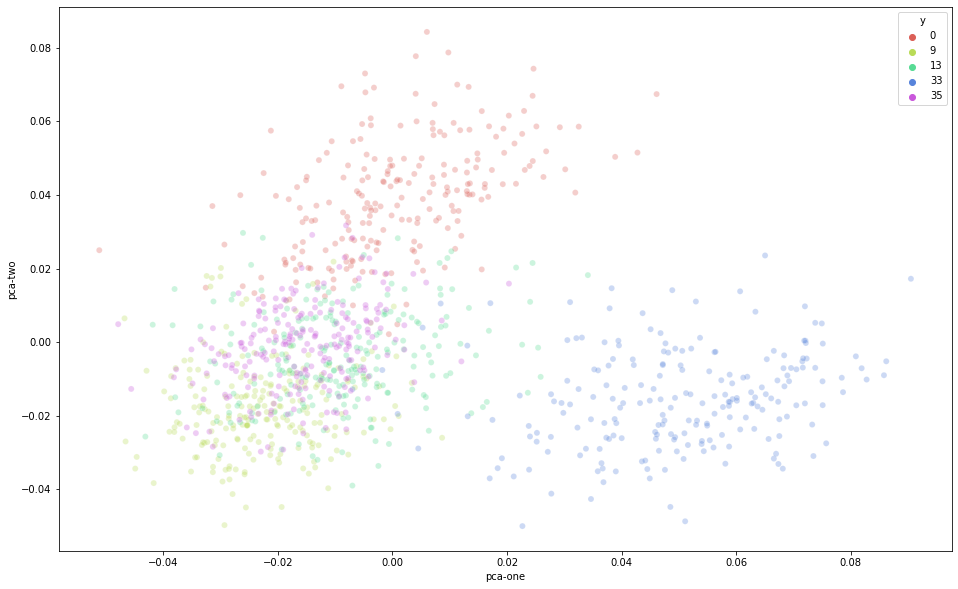

In [41]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", len(selected_classes)),
    data=pca_selected_df,
    legend="full",
    alpha=0.3
)

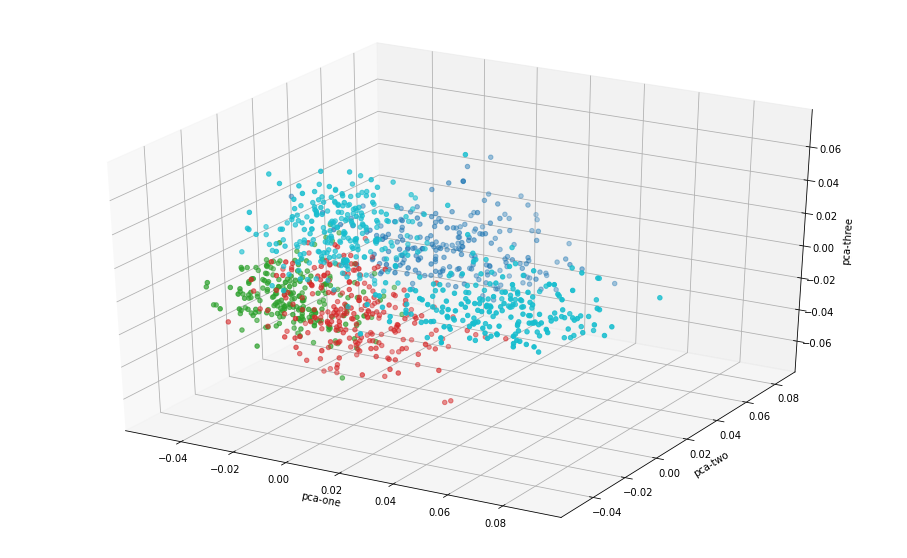

In [53]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
fig = ax.scatter(
  xs = pca_selected_df["pca-one"], 
  ys =pca_selected_df["pca-two"], 
  zs = pca_selected_df["pca-three"], 
  c = pca_selected_df["y"],
  cmap ='tab10'
  )
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')

plt.show()

## T-sne

T-sne al contrario di PCA è in grado di catturare e mantenere le non linearità dei dati. Infatti si può notare subito come per il caso con tutte le classi la separazione sia molto migliore di PCA, addirittura anche nel caso con 5 classi.

In [60]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9231 samples in 0.004s...
[t-SNE] Computed neighbors for 9231 samples in 2.242s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9231
[t-SNE] Computed conditional probabilities for sample 2000 / 9231
[t-SNE] Computed conditional probabilities for sample 3000 / 9231
[t-SNE] Computed conditional probabilities for sample 4000 / 9231
[t-SNE] Computed conditional probabilities for sample 5000 / 9231
[t-SNE] Computed conditional probabilities for sample 6000 / 9231
[t-SNE] Computed conditional probabilities for sample 7000 / 9231
[t-SNE] Computed conditional probabilities for sample 8000 / 9231
[t-SNE] Computed conditional probabilities for sample 9000 / 9231
[t-SNE] Computed conditional probabilities for sample 9231 / 9231
[t-SNE] Mean sigma: 0.025101
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.475670
[t-SNE] KL divergence after 500 iterations: 1.913756


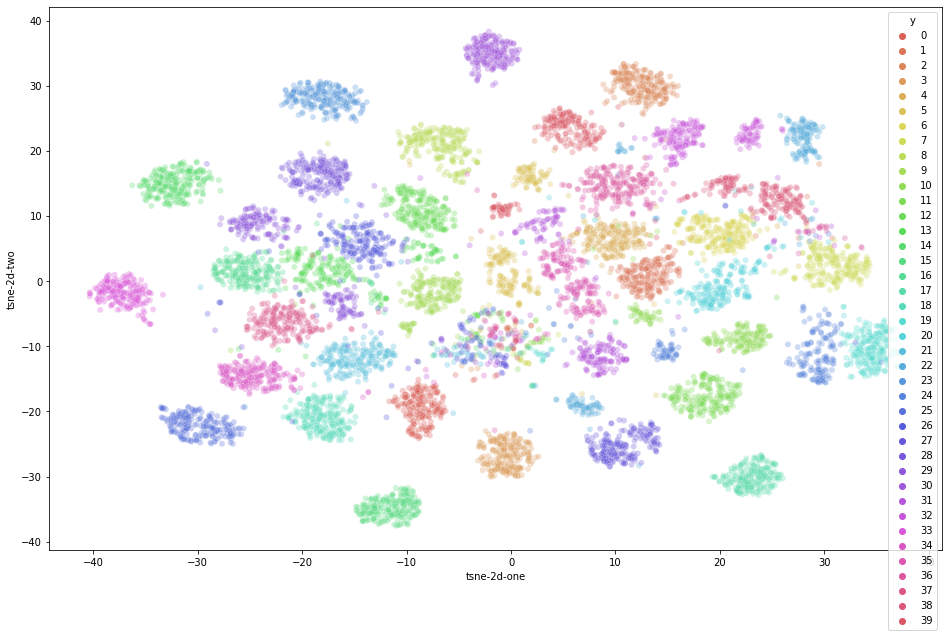

In [61]:
tsne_df = pd.DataFrame()
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]
tsne_df['y'] = labels
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", len(classes)),
    data=tsne_df,
    legend="full",
    alpha=0.3
)

## K-means clustering

A questo punto è possibile utilizzare un metodo di clustering come K-means per individuare i cluster ed assegnare ad ognuno una classe. Come si può vedere dal plot nell'ultima cella la maggior parte di loro è riconosciuta correttamente, ma ci sono alcuni casi in cui sotto lo stesso cluster sono raggruppati sample di classi diverse.

In [89]:
kmeans = KMeans(n_clusters=40)
kmeans.fit(tsne_df.iloc[:, 0:2])

KMeans(n_clusters=40)

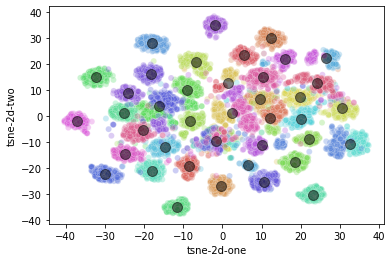

In [96]:
#plt.scatter(tsne_df.iloc[:, 0], tsne_df.iloc[:, 0:1], c=tsne_df.iloc[:, 2], s=50, cmap='viridis')
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", len(classes)),
    data=tsne_df,
    legend=False,
    alpha=0.3
)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5);